#**Social Media Influence on Retail Investors**


In [ ]:


import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA

from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS
import spacy as sp

nlps = sp.load('en')
import numpy as np

import matplotlib.pyplot as plt

plt.rc('figure',figsize=(17,13))
import seaborn as sns
sns.set_style('darkgrid')

from plotly.subplots import make_subplots

import plotly.graph_objs as go

import plotly.express as ex
import matplotlib.dates as mdates
from itertools import islice
from collections import Counter
from nltk.corpus import stopwords




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Host your data in your Google drive and then mount to your Google drive. 
#You will be given an authorization code to finish the process

from  google.colab import drive     
drive.mount('/content/drive')a

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in the training data. The dataset includes two columns: label, sentence 
import pandas as pd
df =pd.read_csv("/content/drive/My Drive/TM/reddit_wsb.csv")
df = df[pd.to_datetime(df.timestamp).dt.year>=2021]
df.head(3)



,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35


In [ ]:
# What is the average length of the title
df1 = df.replace(np.nan, '', regex=True)

df1['len_title']=df1['title'].apply(lambda x : len(x.split(' ')))
df1['len_body']=df1['body'].apply(lambda x : len(x.split(' ')))
df1.describe()

,score,comms_num,created,len_title,len_body
count,45422.000000,45422.000000,4.542200e+04,45422.000000,45422.000000
mean,1454.042909,237.456761,1.613026e+09,11.004954,85.546607
std,8449.893894,2571.269169,1.629286e+06,8.715191,253.700492
min,0.000000,0.000000,1.611818e+09,1.000000,1.000000
25%,1.000000,2.000000,1.611881e+09,5.000000,1.000000
50%,31.000000,13.000000,1.612313e+09,9.000000,1.000000
75%,190.000000,51.000000,1.613758e+09,14.000000,54.000000
max,348241.000000,93268.000000,1.619026e+09,66.000000,6301.000000


In [ ]:
#Remove NAs

# title_data = df[['title','timestamp']].copy()
# body_data = df[['body','timestamp']].copy()
# body_data = body_data.dropna()
# title_data = title_data.dropna()

In [ ]:
#Text Preprocessing
#Remove NAs
title_data = df[['title','timestamp']].copy()
body_data = df[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()


#lower_case
title_data.title =title_data.title.str.lower()
body_data.body =body_data.body.str.lower()
body_data.body[2]

'the ceo of nasdaq pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[https://mobile.twitter.com/mediaite/status/1354504710695362563](https://mobile.twitter.com/mediaite/status/1354504710695362563)\n\nnow sec is investigating, brokers are disallowing buying more calls. this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing uber on the side?”\n\nwe may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. the media wants to pin the blame on us.\n\nit should be crystal clear that this is a rigged game by now. its time

In [ ]:
#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body[2]

'the ceo of nasdaq pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[https://mobile.twitter.com/mediaite/status/1354504710695362563](https://mobile.twitter.com/mediaite/status/1354504710695362563)\n\nnow sec is investigating, brokers are disallowing buying more calls. this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing uber on the side?”\n\nwe may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. the media wants to pin the blame on us.\n\nit should be crystal clear that this is a rigged game by now. its time

In [ ]:
# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body[2]

'the ceo of nasdaq pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[\n\nnow sec is investigating, brokers are disallowing buying more calls. this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing uber on the side?”\n\nwe may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. the media wants to pin the blame on us.\n\nit should be crystal clear that this is a rigged game by now. its time to build new exchanges that can’t arbitrarily change the rules on us. cr\\*\\*o has some version of these, maybe they can be r

In [ ]:
# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body[2]

'the ceo of nasdaq pushed to halt trading to give investors a chance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we get a well shucks you should have known investing is risky have you tried cutting out avocados and coffee maybe doing uber on the side we may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us we do not have the money to move the stock as much as it did alone we didn t hurt wall street as a whole just a few funds went down while others went up and profited off the shorts the same as us the media wants to pin the blame on us it should be crystal clear that this is a rigged game by now its time to build new exchanges that can t arbitrarily change the rules on us cr o has some version of these maybe they can be repurposed to be trade stock without gov

In [ ]:
#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
body_data.body[2]

'the ceo of nasdaq pushed to halt trading to give investors chance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we get well shucks you should have known investing is risky have you tried cutting out avocados and coffee maybe doing uber on the side we may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us we do not have the money to move the stock as much as it did alone we didn hurt wall street as whole just few funds went down while others went up and profited off the shorts the same as us the media wants to pin the blame on us it should be crystal clear that this is rigged game by now its time to build new exchanges that can arbitrarily change the rules on us cr has some version of these maybe they can be repurposed to be trade stock without government interven

In [ ]:
# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.timestamp[2]

'2021-01-28 21:30:35'

In [ ]:
#Remove Time From Timestamp
# title_data_time = title_data[['title','timestamp']].copy()
# body_data_time = title_data[['body','timestamp']].copy()


title_data["date"] = pd.to_datetime(title_data.timestamp).dt.date
body_data["date"] = pd.to_datetime(body_data.timestamp).dt.date
body_data.head(3)


,body,timestamp,date
2,the ceo of nasdaq pushed to halt trading to gi...,2021-01-28 21:30:35,2021-01-28
6,hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27,2021-01-28
7,life isn fair my mother always told me that wh...,2021-01-28 21:19:31,2021-01-28


In [ ]:
b_date_count = title_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'title':'Posts_Per_Day'})
b_date_count.head(10)

b_date_count.Posts_Per_Day.astype(int)

print(b_date_count.head(5))
print(b_date_count['Posts_Per_Day'].mean())

         date  Posts_Per_Day  timestamp
0  2021-01-28           1197       1197
1  2021-01-29          15694      15694
2  2021-01-30           1424       1424
3  2021-01-31            939        939
4  2021-02-01            884        884
540.7380952380952


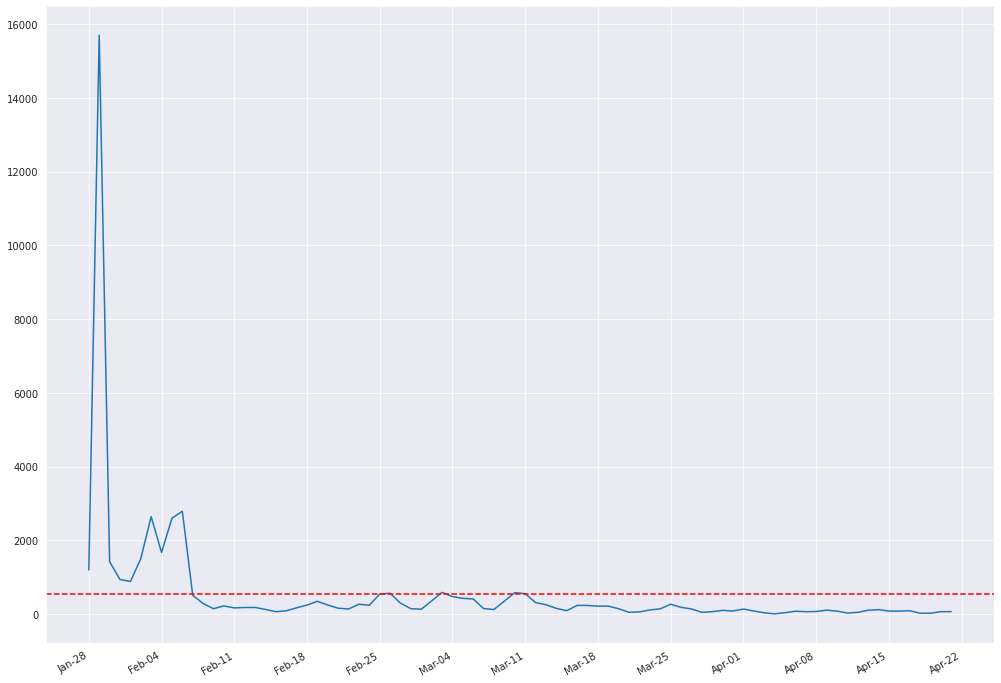

In [ ]:
#Daily number of posts

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.plot(b_date_count.date, b_date_count.Posts_Per_Day)
plt.gcf().autofmt_xdate()
plt.axhline(y = b_date_count['Posts_Per_Day'].mean(), color = 'r', linestyle = 'dashed', label = "red line")    

plt.show()


What happened on 29th Jan??

In [ ]:


stop_words = set(stopwords.words('english'))  

def create_text_blob(df, text_column):
    blob_text=[]
    for i, content in df[text_column].items():
        for i in content.split():
            blob_text.append(i.lower())
    return blob_text

blob_text = create_text_blob(title_data, 'title')
print(blob_text[0:100])

filtered_sentence = [w for w in blob_text if not w in stop_words]  
filtered_sentence = []  
  
for w in blob_text:  
    if w not in stop_words:  
        filtered_sentence.append(w)  

print(filtered_sentence[0:100])  

['it', 'not', 'about', 'the', 'money', 'it', 'about', 'sending', 'message', 'math', 'professor', 'scott', 'steiner', 'says', 'the', 'numbers', 'spell', 'disaster', 'for', 'gamestop', 'shorts', 'exit', 'the', 'system', 'new', 'sec', 'filing', 'for', 'gme', 'can', 'someone', 'less', 'retarded', 'than', 'me', 'please', 'interpret', 'not', 'to', 'distract', 'from', 'gme', 'just', 'thought', 'our', 'amc', 'brothers', 'should', 'be', 'aware', 'of', 'this', 'we', 'breaking', 'through', 'short', 'stock', 'doesn', 'have', 'an', 'expiration', 'date', 'this', 'is', 'the', 'moment', 'currently', 'holding', 'amc', 'and', 'nok', 'is', 'it', 'retarded', 'that', 'think', 'should', 'move', 'it', 'all', 'to', 'gme', 'today', 'i', 'have', 'nothing', 'to', 'say', 'but', 'bruh', 'am', 'speechless', 'to', 'the', 'moon', 'we', 'need', 'to', 'keep', 'this']
['money', 'sending', 'message', 'math', 'professor', 'scott', 'steiner', 'says', 'numbers', 'spell', 'disaster', 'gamestop', 'shorts', 'exit', 'system', '

In [ ]:
#finding robinhood

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

l=Counter(filtered_sentence)
l1=dict(sorted(l.items(), key=lambda item: item[1], reverse=True))
take(20, l1.items())


[('gme', 8686),
 ('buy', 3841),
 ('hold', 3284),
 ('amc', 3269),
 ('robinhood', 3197),
 ('holding', 1989),
 ('still', 1873),
 ('stock', 1857),
 ('moon', 1663),
 ('like', 1637),
 ('shares', 1577),
 ('sell', 1574),
 ('yolo', 1383),
 ('short', 1352),
 ('let', 1336),
 ('bought', 1314),
 ('get', 1288),
 ('today', 1285),
 ('bb', 1271),
 ('going', 1244)]

In [ ]:
import plotly.express as px

counts = Counter(filtered_sentence)
top_20_words = {}
i=0
for (key, value) in counts.items():
   # Check if value is greater than 200 and add to new dictionary
    if value > 700 :
        top_20_words[key] = value
        i=i+1


sorted_top_20_words = dict(sorted(top_20_words.items(), key=lambda item: item[1], reverse=True))

word = sorted_top_20_words.keys()
count = sorted_top_20_words.values()

print(sorted_top_20_words['robinhood'])

3197


In [ ]:
#finding robinhood
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

final=take(20, sorted_top_20_words.items())
my_dict = dict(final)

<BarContainer object of 20 artists>

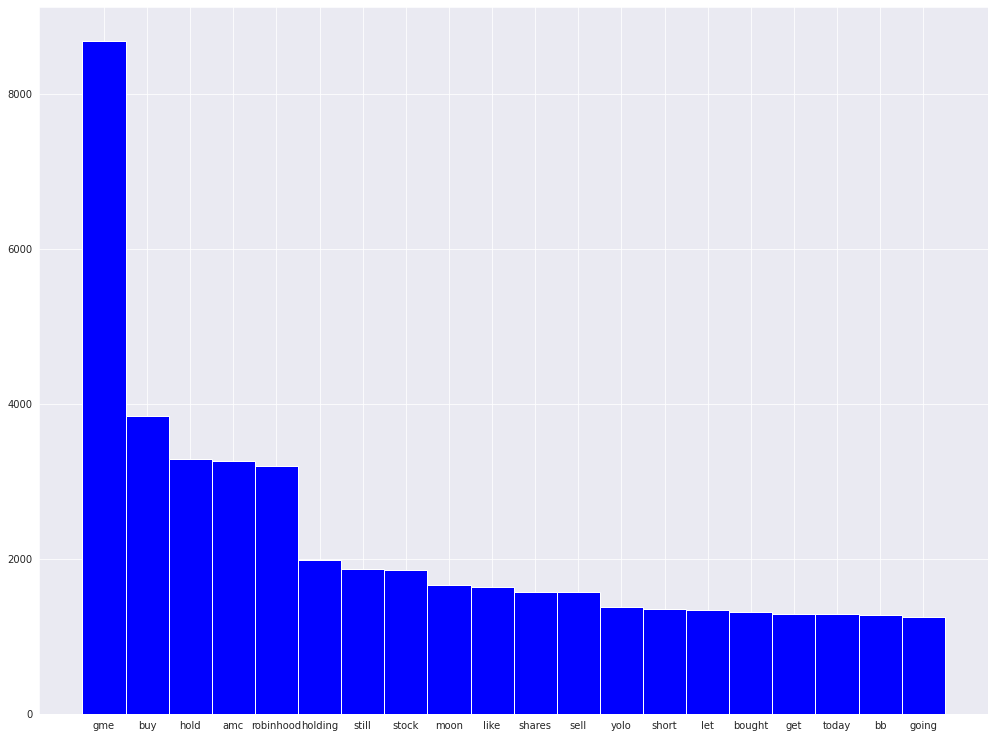

In [ ]:
plt.bar(my_dict.keys(), my_dict.values(), width=1, color='b')


Ketwords: gme, buy, hold, stock, sell, short, bought, 

In [ ]:
sia = SIA()
body_data['sentiments']           = body_data['body'].apply(lambda x: sia.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
body_data['Compound Sentiment']   = body_data['sentiments'].apply(lambda x: x['compound']+1*(10**-6))

body_data.drop(columns=['sentiments'],inplace=True)


title_data['sentiments']           = title_data['title'].apply(lambda x: sia.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment']   = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment']    = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment']   = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
title_data['Compound Sentiment']   = title_data['sentiments'].apply(lambda x: x['compound']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)

In [ ]:
title_data['title'][0]

'it not about the money it about sending message'

In [ ]:
pip install yfinance


     |████████████████████████████████| 6.3MB 11.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=d6e8b0aa0575b257694951a01973d87d0f270e57a76d18602a384caabda37b74
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
pip install yahoofinancials


  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=20f9e93f0880c2f8e40b215e60f98b75b983072ba54377224ec551acb28e1308
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


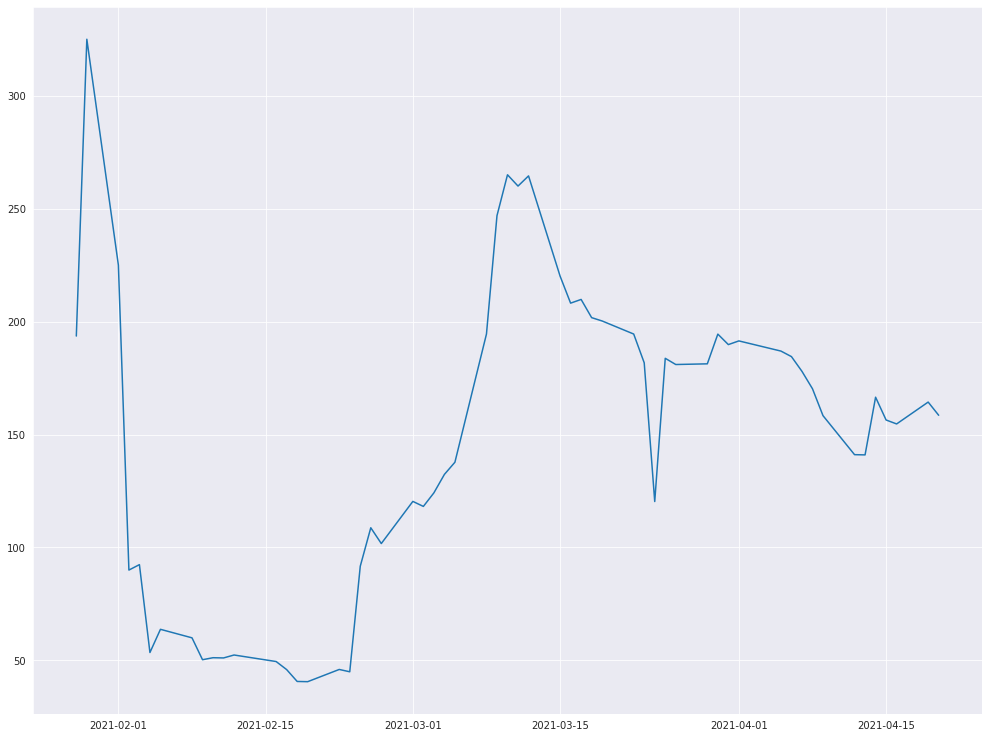

In [ ]:
plt.plot(df["Close"])

[*********************100%***********************]  1 of 1 completed


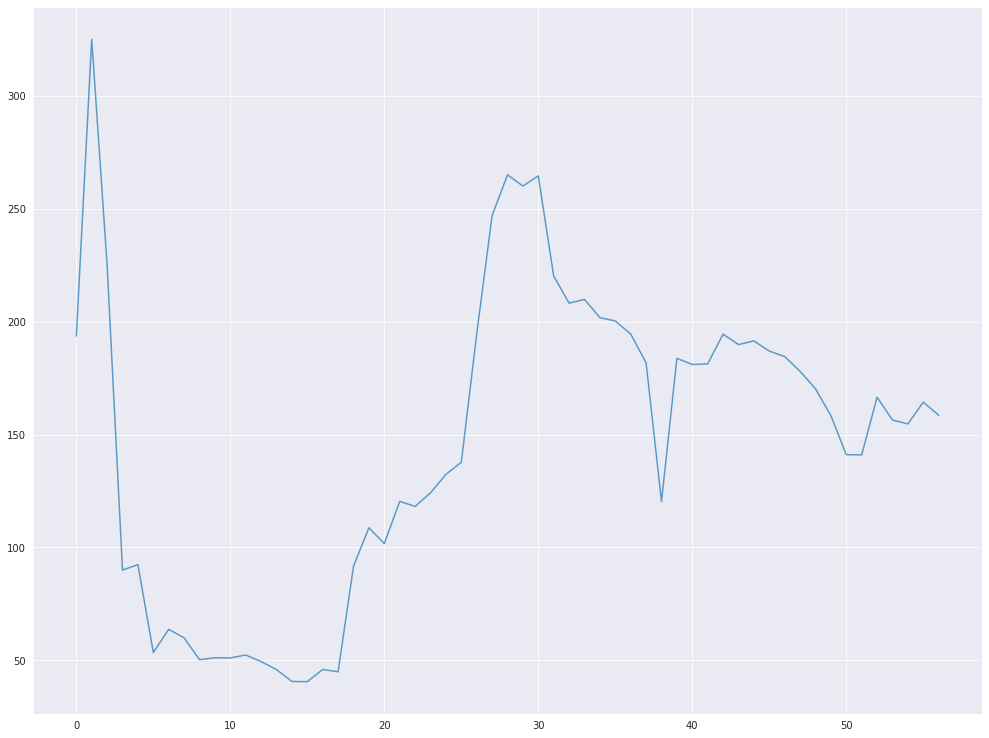

In [ ]:



import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
data=['GME']
yahoo_financials = YahooFinancials(data)
data = yahoo_financials.get_historical_price_data(start_date='2021-01-28', 
                                                  end_date='2021-04-21', 
                                                  time_interval="daily")


df = yf.download("GME", start="2021-01-28", end="2021-04-21",group_by="ticker")

plt.plot(np.arange(len(df)), df.Close, alpha=0.7, label='Close' )


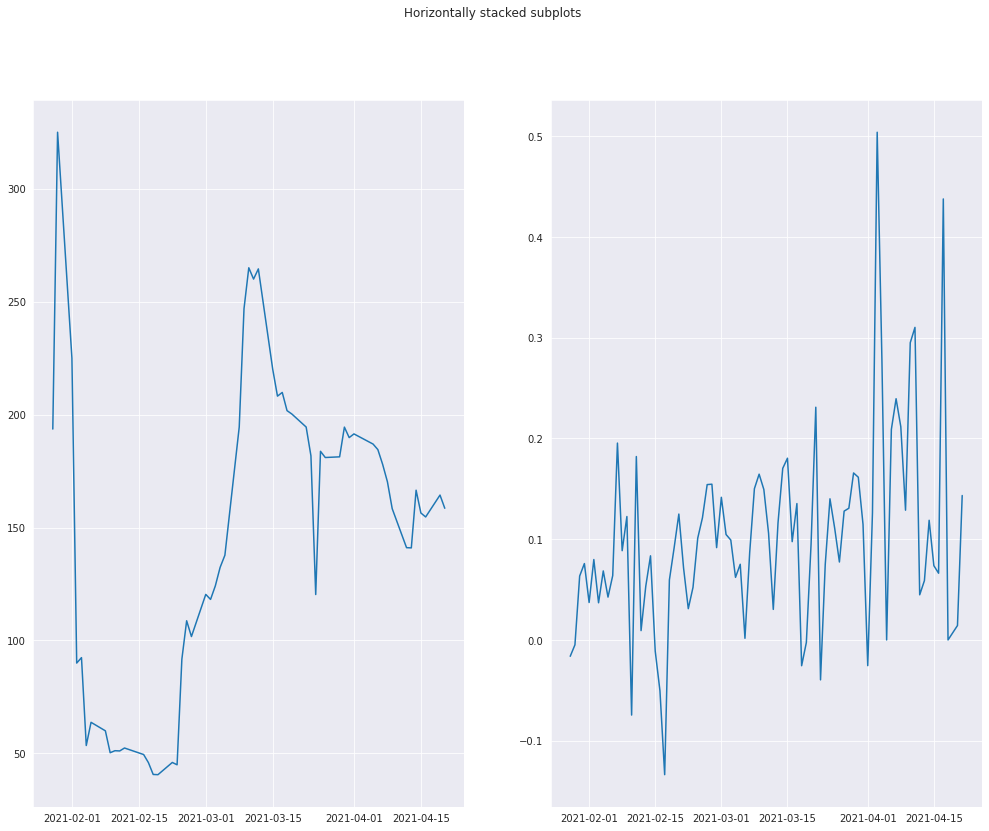

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(df["Close"])
ax2.plot(pg_gme.date, pg_gme['Compound Sentiment'])

In [ ]:
# pg[pg["date"]==date("2021-01-28")]

#pd.to_datetime("2021-01-28")==


# pg["date"][0]==pd.to_datetime("2021-01-28")

In [ ]:
data_compare=title_data[title_data['title'].str.contains("gme")].reset_index()


In [ ]:
norm_price=2*(df["Close"]/max(df["Close"]))-.5
norm_price=df["Close"]/max(df["Close"])/3
norm_price=np.log(df["Close"])/max(np.log(df["Close"]))-.8

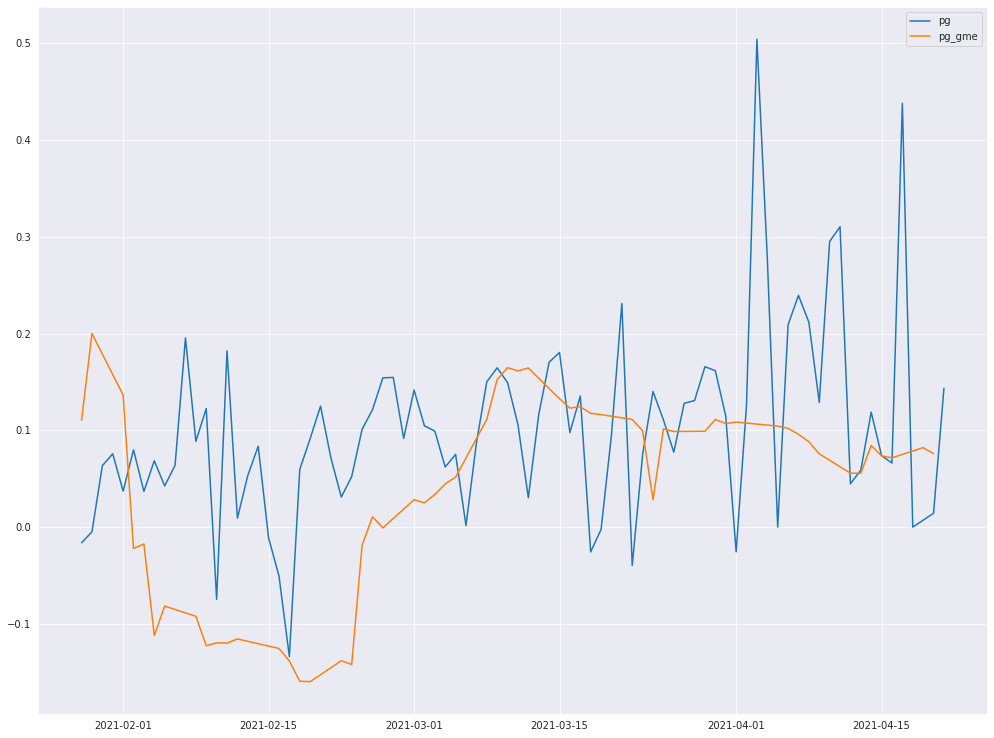

In [ ]:
pg=title_data.groupby('date')['Compound Sentiment'].mean().reset_index()
pg_gme=data_compare.groupby('date')['Compound Sentiment'].mean().reset_index()


#plt.plot(pg.date, pg['Compound Sentiment'])

plt.plot(pg_gme.date, pg_gme['Compound Sentiment'])
plt.plot(norm_price)

plt.legend(["pg", "pg_gme","norm_price"])

In [ ]:
#Title Text Sentiment Analysis


plt.title('CDF Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

In [ ]:
#Sorting And Feature Engineering
f_data = title_data.sort_values(by='timestamp')
ft_data=f_data.copy()
ft_data = ft_data.rename(columns={'timestamp':'date'})
ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

In [ ]:
#Naive Feature Extration
body_data['# Of Words']          = body_data['body'].apply(lambda x: len(x.split(' ')))
body_data['# Of StopWords']      = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
body_data['Average Word Length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

title_data['# Of Words']          = title_data['title'].apply(lambda x: len(x.split(' ')))
title_data['# Of StopWords']      = title_data['title'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
title_data['Average Word Length'] = title_data['title'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))



In [ ]:
body_data.describe()

In [ ]:
#Named Entity Extraction

title_data['# Of Times Currency Was Mentioned']          = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
title_data['# Of Organizations Mentioned']           = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))

print('Processed Title DataFrame')
body_data['# Of Times Currency Was Mentioned']          = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
body_data['# Of Organizations Mentioned']           = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))
print('Processed Body DataFrame')

In [ ]:
b_date_mean = ft_data.groupby(by='date').mean().reset_index()
b_date_std = ft_data.groupby(by='date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)




fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()

In [ ]:
#PCA
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize


NUMBER_OF_COMPONENTS = 450

CVZ = CountVectorizer()
SVD = TruncatedSVD(NUMBER_OF_COMPONENTS)

text_data = f_data.title.copy()
text_data = text_data.apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS and len(word) > 1]).strip())

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

text_data = text_data.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
text_data = text_data.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

C_vector = CVZ.fit_transform(text_data)


pc_matrix = SVD.fit_transform(C_vector)

evr = SVD.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar", 
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(     title='{:.2f}% of the Post Text Variance Can Be Explained Using {} Words'.format(np.sum(evr)*100,NUMBER_OF_COMPONENTS))


In [ ]:
b_date_count = ft_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'title':'Posts Per Day'})
fig = ex.line(b_date_count,x='date',y='Posts Per Day')


fig.add_shape(type="line",
    x0=b_date_count['date'].values[0], y0=b_date_count['Negative Sentiment'].mean(), x1=b_date_count['date'].values[-1], y1=b_date_count['Negative Sentiment'].mean(),
    line=dict(
        color="black",
        width=2,
    ),
        name='Mean',
)

fig.update_traces(mode="markers+lines")
fig.update_layout(hovermode="x")


fig.update_layout(title='<b>Daily Post Count<b>')
fig.show()

In [ ]:
Most_Positive = title_data[title_data['Positive Sentiment'].between(0.4,1)]['title']
Most_Negative = title_data[title_data['Negative Sentiment'].between(0.25,1)]['title']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)


pwc = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(Most_Negative_text)

plt.title('Common Words Among Most Positive Post Titles',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')


In [ ]:
#plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Post Titles',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

##We can label our data based on whether or not the title contains the GameStop ticker (GME):

In [ ]:
import numpy as np
df = df.fillna("") 
#df['GME_title'] = np.where(df['title'].str.contains('GME'), 1, 0)
#print(df[['title','GME_title']].head())

# df['GME_body'] = np.where(df['body'].str.contains('GME'), 1, 0)
# print(df[['title','body','GME_body']].head())

In [ ]:
df['title_body']=df['title']+'-'+df['body']


In [ ]:
#todo: convert lower and then process
df['title_body']=df['title_body'].str.lower()

In [ ]:
#todo: get rid of links regix

In [ ]:
d=df['body'][df['body']!=""]
d = d.reset_index(drop=True)

In [ ]:
d[0]

In [ ]:
#todo: add more combinations 

In [ ]:
df['GME_title_body'] = np.where(df['title_body'].str.contains('gme'), 1, 0)


In [ ]:
print(df[['title_body','GME_title_body']].head())

In [ ]:
from collections import Counter        
def return_counter(data_frame, column_name):
  print(dict(Counter(data_frame[column_name].values)))

return_counter(df, 'GME_title_body')

In [ ]:
df['ticker'] = np.where(df['GME_title_body'] ==1, 'GME', 'Other')


In [ ]:
df_GME = df[df['GME_title_body']==1]
print(df_GME.head())

In [ ]:
def get_boxplot_of_categories(data_frame, categorical_column, numerical_column):
    import seaborn as sns
    from collections import Counter
    keys = []
    for i in dict(Counter(df[categorical_column].values)):
        keys.append(i)
    print(keys)
    df_new = df[df[categorical_column].isin(keys)]
    sns.set()
    sns.boxplot(x = df_new[categorical_column], y =      df_new[numerical_column])

In [ ]:
get_boxplot_of_categories(df, 'ticker', 'score')


In [ ]:
def get_histogram(data_frame, numerical_column):
    df_new = data_frame
    df_new[numerical_column].hist(bins=100)

In [ ]:
get_histogram(df, 'score')


We can also get sentiment scores for each of the posts.We will use the polarity score as our measure for positive or negative sentiment. The polarity score is a float with values from -1 to +1

In [ ]:
from textblob import TextBlob
def get_sentiment():
    df['sentiment'] = df['title_body'].apply(lambda title: TextBlob(title).sentiment.polarity)
    df_pos = df[df['sentiment'] > 0.0]
    df_neg = df[df['sentiment'] < 0.0]
    print("Number of Positive Posts", len(df_pos))
    print("Number of Negative Posts", len(df_neg))

In [ ]:
get_sentiment()

In [ ]:
def get_sentiment(df):
    df['sentiment'] = df['title_body'].apply(lambda title: TextBlob(title).sentiment.polarity)
    df_pos = df[df['sentiment'] > 0.0]
    df_neg = df[df['sentiment'] < 0.0]
    print("Number of Positive Posts", len(df_pos))
    print("Number of Negative Posts", len(df_neg))
    return df 
df_new = get_sentiment(df_GME)
print(df_new.head())

In [ ]:
#df_new=df
print(df_new.head())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_sentiment(df):
    df['sentiment'] = df['title_body'].apply(lambda title: TextBlob(title).sentiment.polarity)
    df_pos = df[df['sentiment'] > 0.0]
    df_neg = df[df['sentiment'] < 0.0]
    print("Number of Positive Posts", len(df_pos))
    print("Number of Negative Posts", len(df_neg))
    print(100*len(df_pos)/(len(df_pos)+len(df_neg)),100*len(df_neg)/(len(df_pos)+len(df_neg)))
    
    sns.set()
    labels = ['Postive', 'Negative']
    heights = [len(df_pos), len(df_neg)]
    plt.bar(labels, heights, color = 'navy')
    plt.title('GME Posts Sentiment')
    return df
df = get_sentiment(df_GME)

In [ ]:
#df_3=df
# print(df_3.head())

In [ ]:
min(df_new['timestamp'])

In [ ]:
max(df_new['timestamp'])